In [29]:
# Configure for Platform
import os
from pathlib import Path
import sys

if Path("/kaggle").exists():
    platform = "kaggle"
    sys.path.append("/kaggle/input/sicheng-ml-lib")
    OUTPUT_DIR = Path("/kaggle/working/")
else:
    platform = "local"
    os.environ["KERAS_BACKEND"] = "jax"
    OUTPUT_DIR = Path("../../output/")
print(f"the platform is {platform}")

the platform is local


In [30]:
import pandas as pd
import numpy as np
from mylib import kaggle_datasets
import matplotlib.pyplot as plt
import seaborn as sns


handles = [
    "ryanholbrook/ts-course-data",
    "competitions/store-sales-time-series-forecasting",
]

plt.rc("figure", figsize=(11, 6))
%config InlineBackend.figure_format = 'retina'
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [31]:
book_sales = pd.read_csv(
    kaggle_datasets(handles[0]) / "book_sales.csv",
    index_col="Date",
    parse_dates=["Date"],
).drop("Paperback", axis=1)
book_sales["Time"] = np.arange(len(book_sales.index))
book_sales["Lag_1"] = book_sales["Hardcover"].shift(1)
book_sales = book_sales.reindex(columns=["Hardcover", "Time", "Lag_1"])
print("book_sales:\n", book_sales.head())

ar = pd.read_csv(
    kaggle_datasets(handles[0]) / "ar.csv",
)
print("ar:\n", ar.head())

store_sales = pd.read_csv(
    kaggle_datasets(handles[1]) / "train.csv",
    dtype={
        "store_nbr": "category",
        "family": "category",
        "sales": "float32",
        "onpromotion": "uint64",
    },
    parse_dates=["date"],
)
store_sales = store_sales.set_index("date").to_period("D")
store_sales = store_sales.set_index(["store_nbr", "family"], append=True)
print("store_sales:\n", store_sales.head())
average_sales = store_sales.groupby("date").mean()["sales"]
print("average_sales:\n", average_sales.head())

book_sales:
             Hardcover  Time  Lag_1
Date                              
2000-04-01        139     0    NaN
2000-04-02        128     1  139.0
2000-04-03        172     2  128.0
2000-04-04        139     3  172.0
2000-04-05        191     4  139.0
ar:
         ar1       ar2
0  0.541286 -1.234475
1 -1.692950  3.532498
2 -1.730106 -3.915508
3 -0.783524  2.820841
4 -1.796207 -1.084120
store_sales:
                                  id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0
average_sales:
 date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32


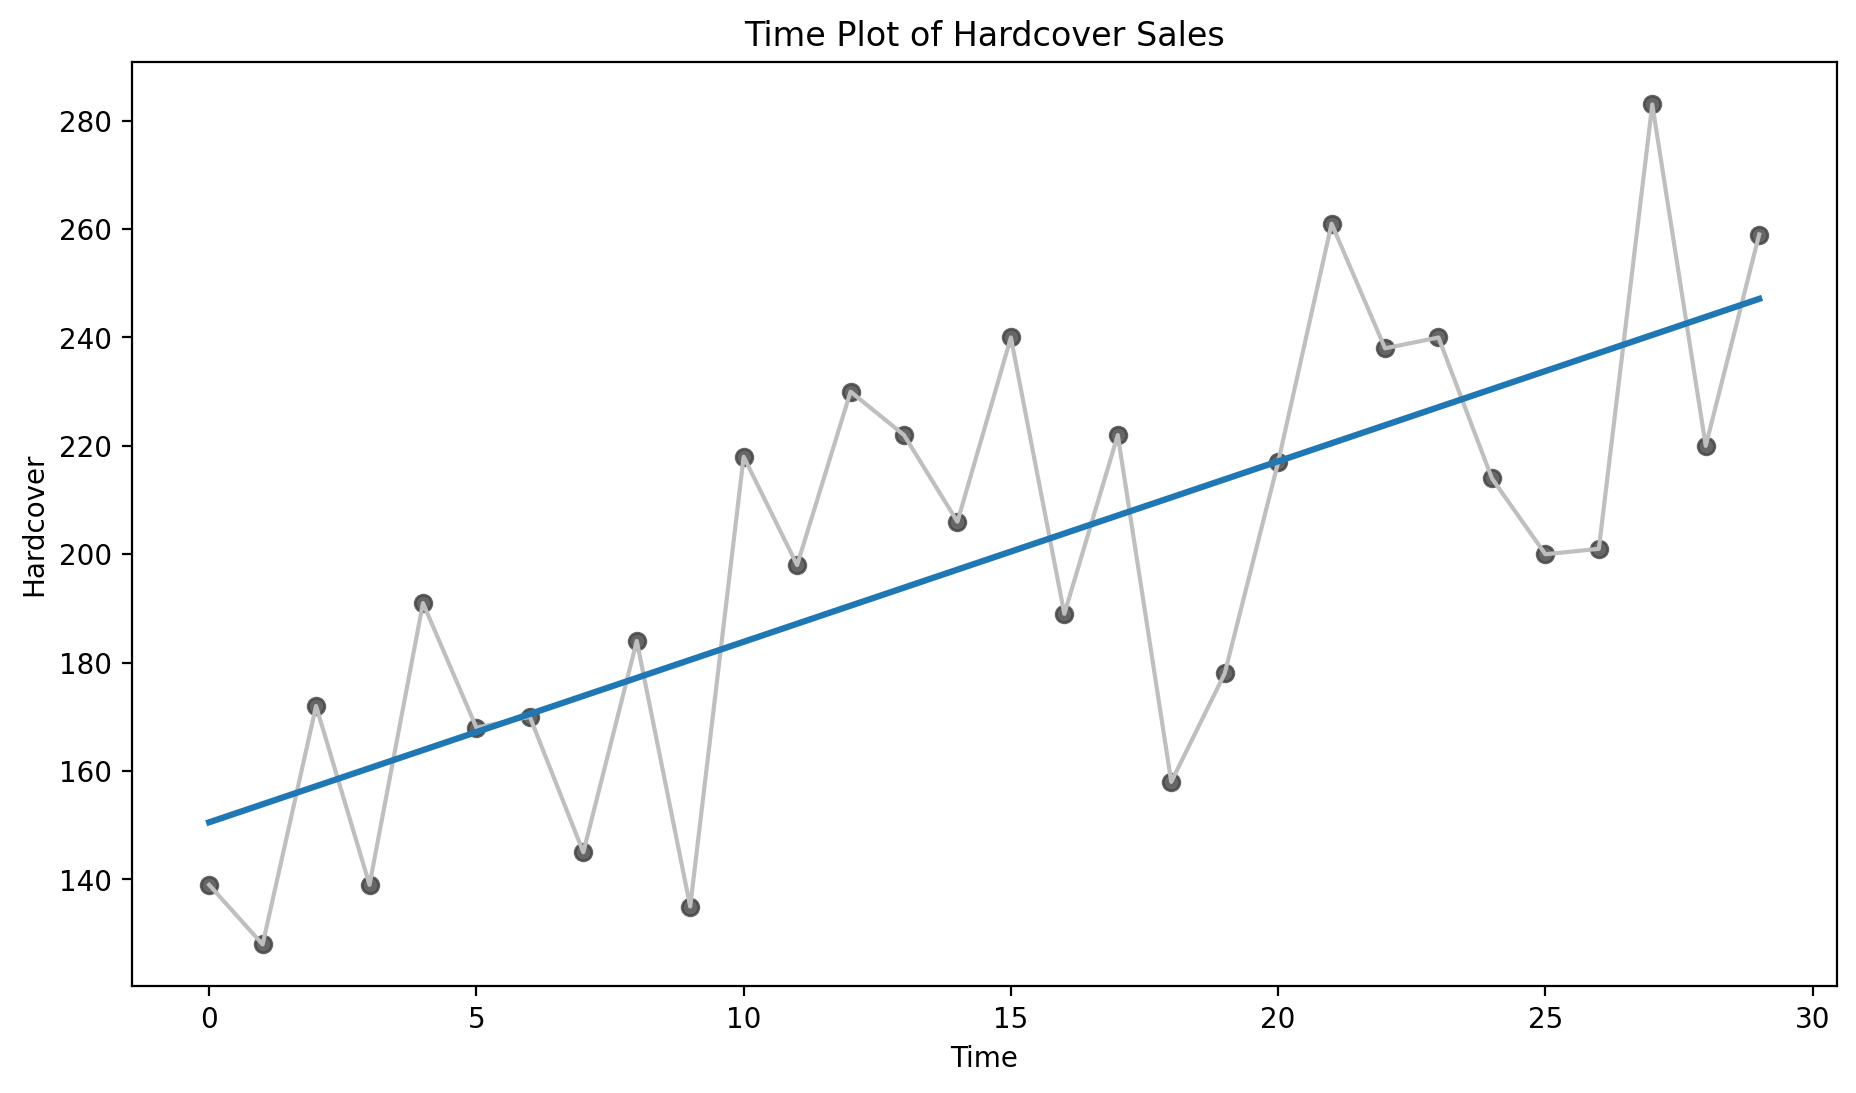

In [32]:
plt.plot("Time", "Hardcover", data=book_sales, color="0.75")
sns.regplot(
    x="Time", y="Hardcover", data=book_sales, ci=None, scatter_kws=dict(color="0.25")
)
plt.title("Time Plot of Hardcover Sales")
plt.show()

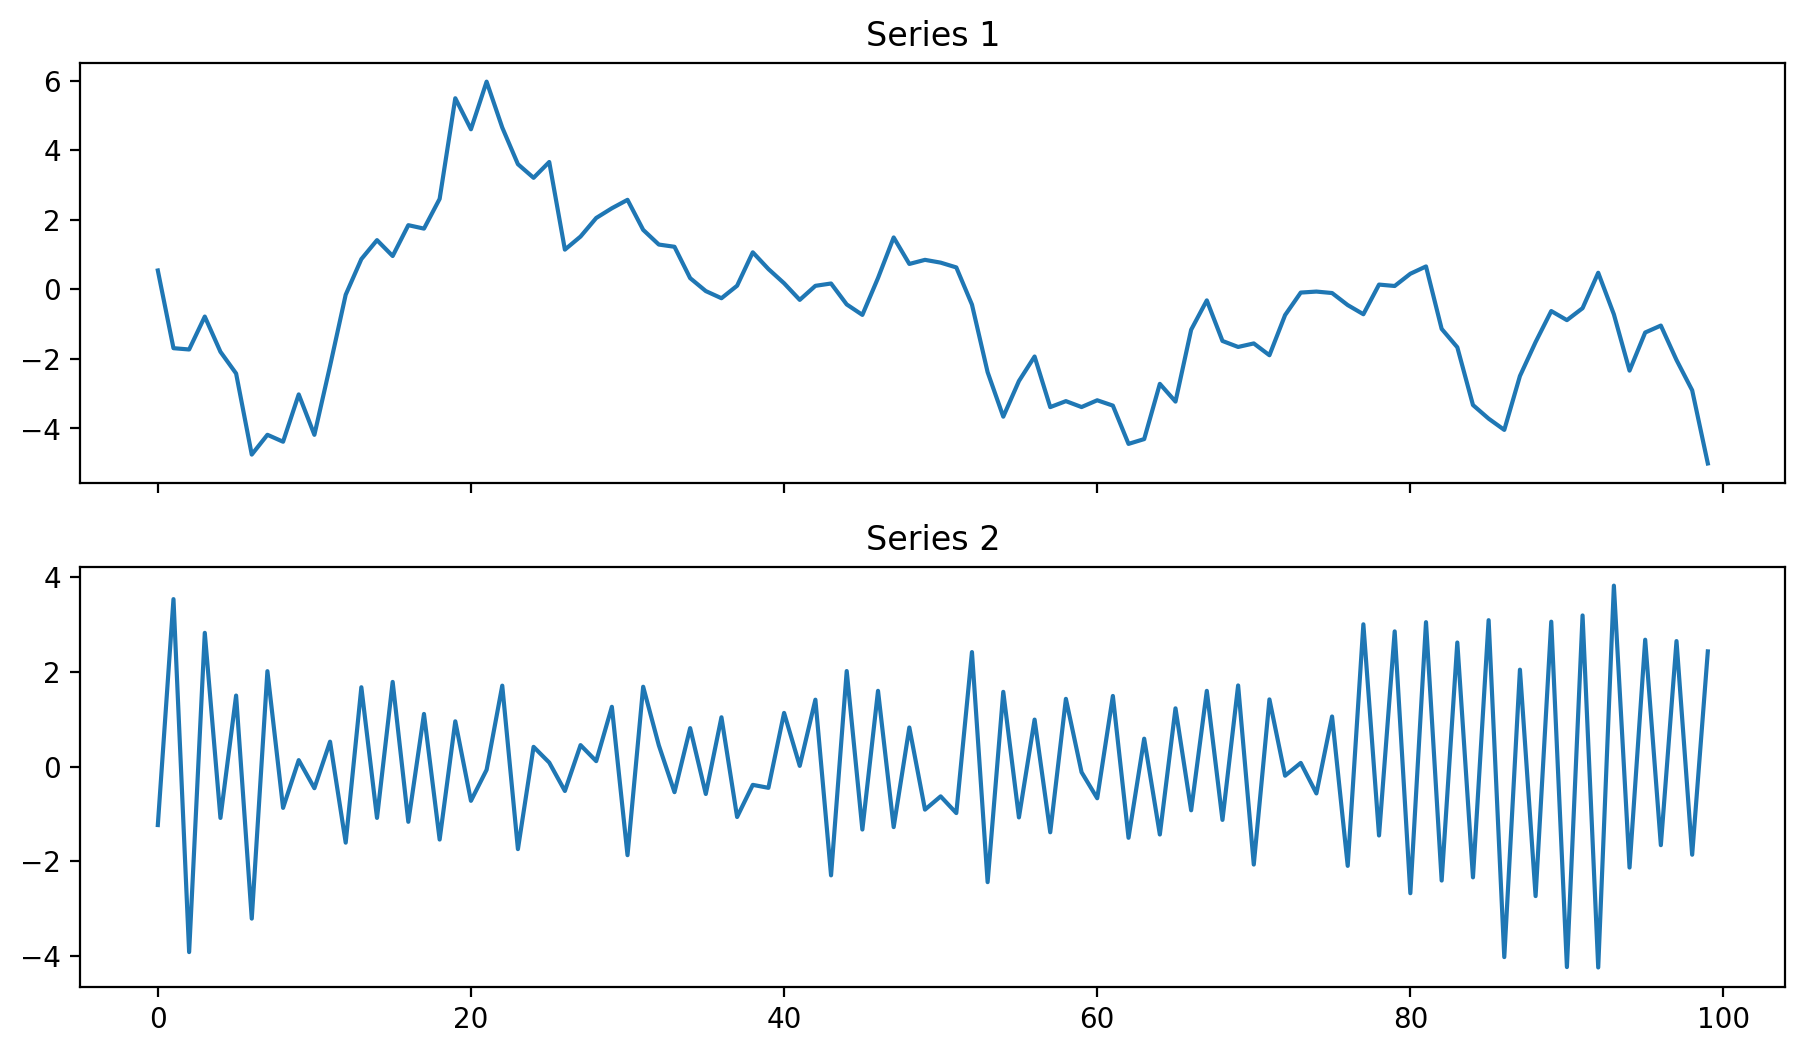

In [33]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ar["ar1"])
axes[0].set_title("Series 1")
axes[1].plot(ar["ar2"])
axes[1].set_title("Series 2")
plt.show()

df:
                  sales
date                  
2013-01-01    1.409438
2013-01-02  278.390808
2013-01-03  202.840195
2013-01-04  198.911163
2013-01-05  267.873260


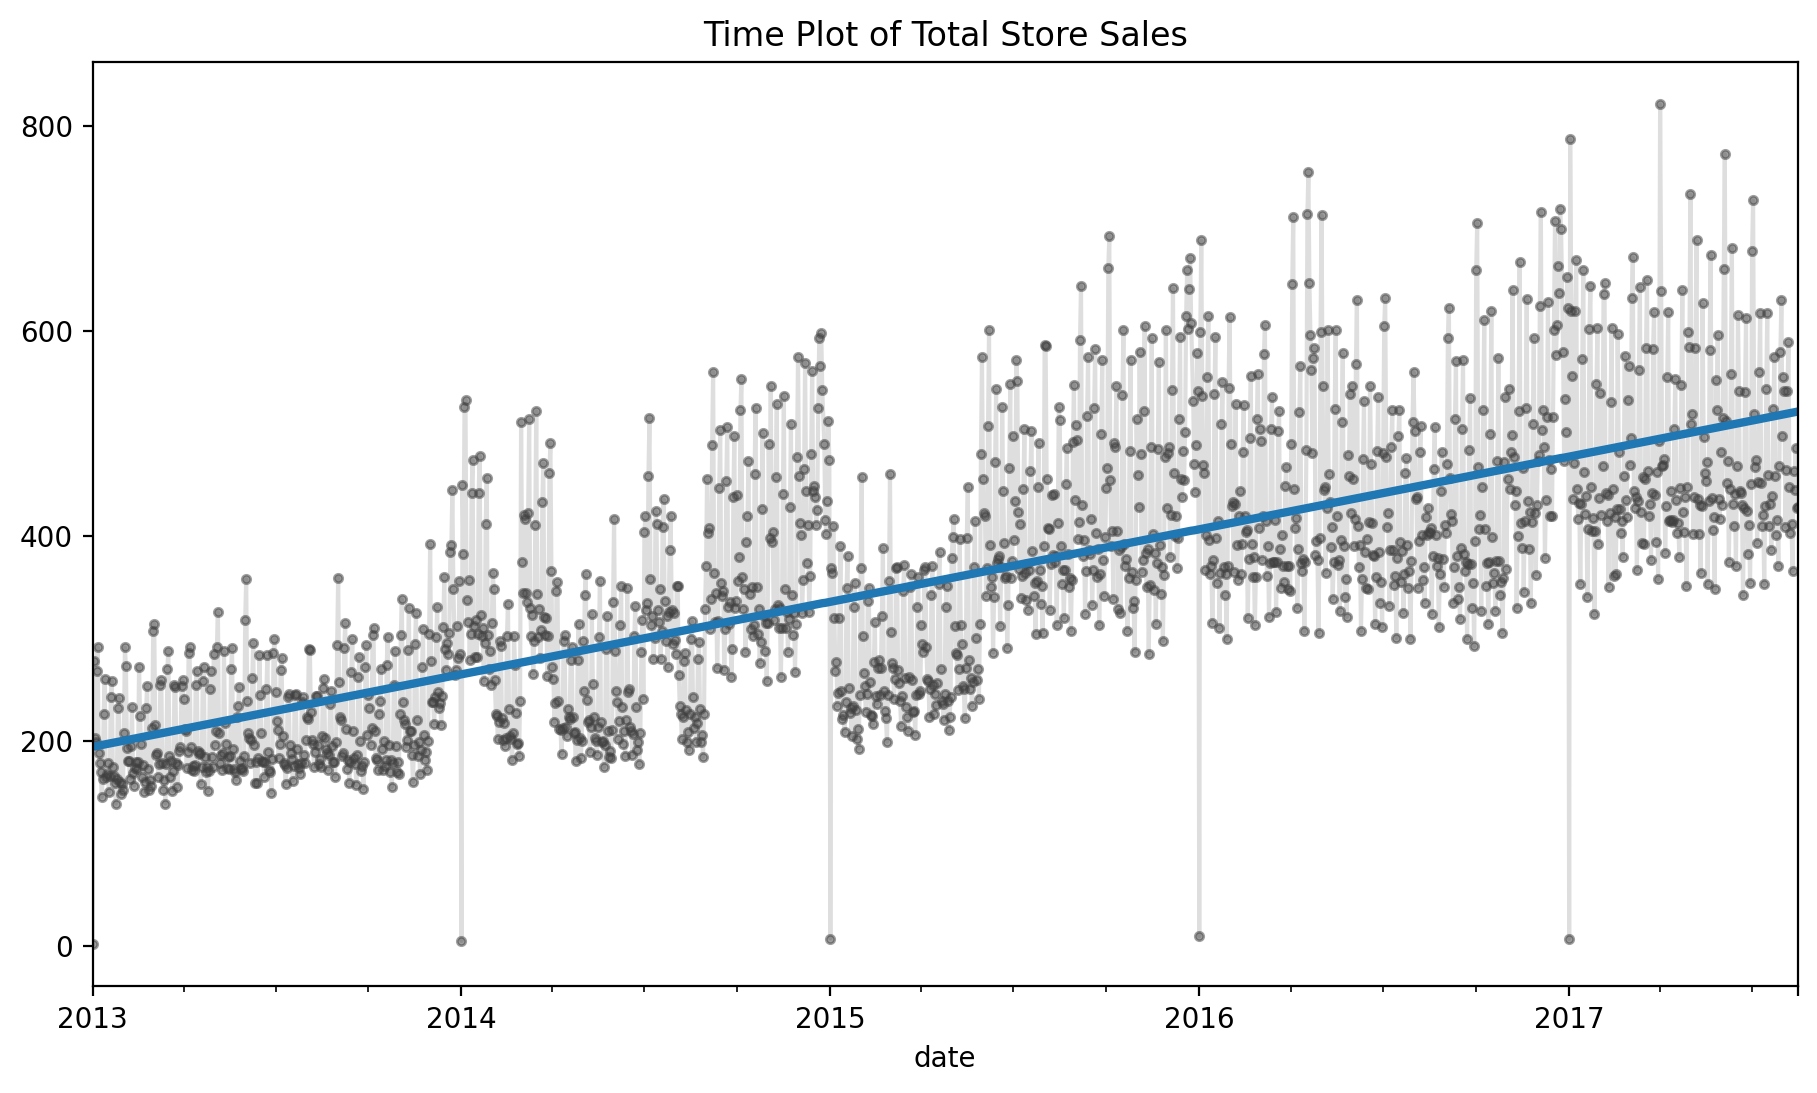

In [34]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()
print("df:\n", df.head())
df["time"] = np.arange(len(df))
X = df.loc[:, ["time"]]
y = df.loc[:, "sales"]
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y.plot(**plot_params, alpha=0.5)
y_pred.plot(linewidth=3)
plt.title("Time Plot of Total Store Sales")
plt.show()

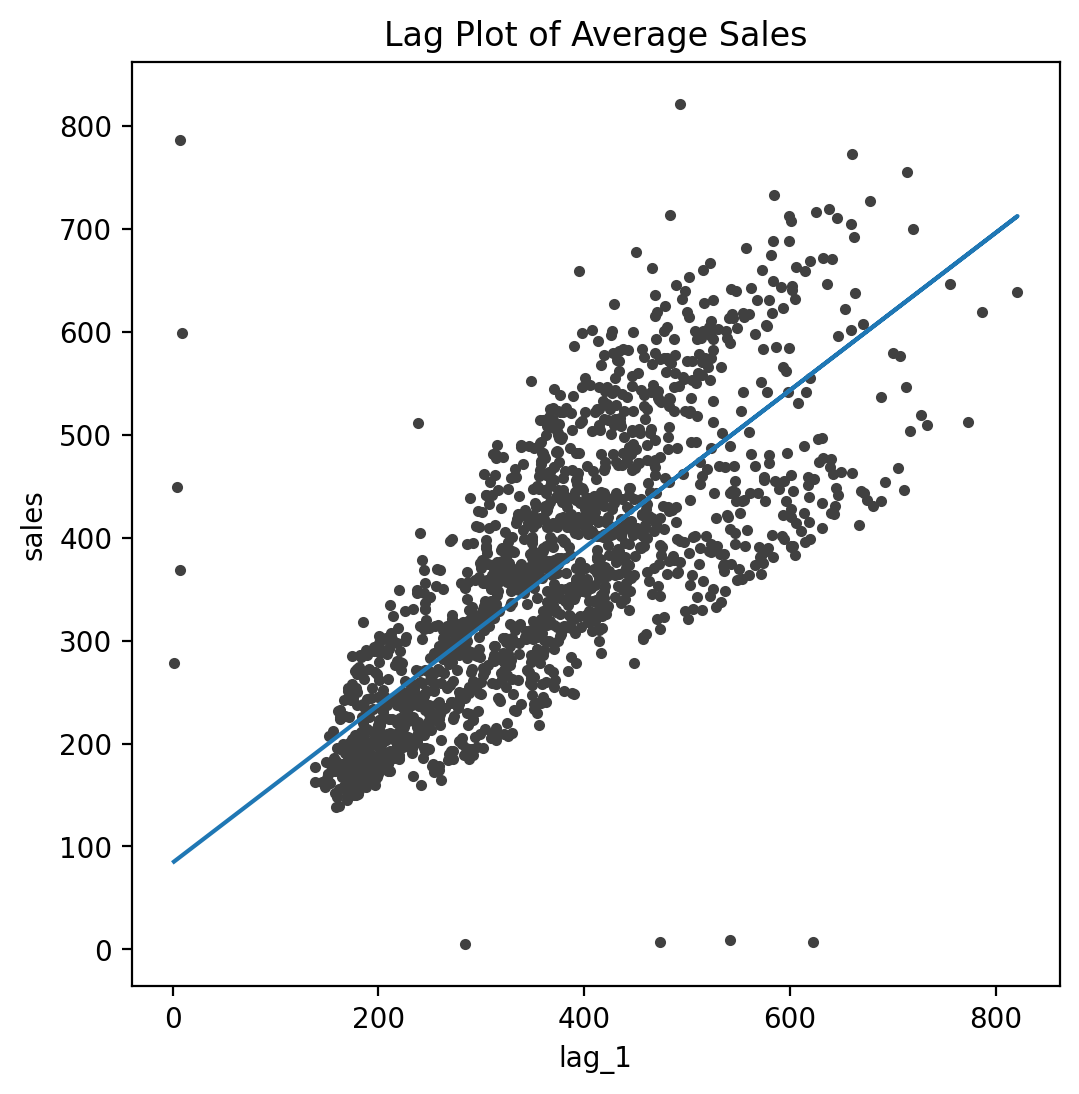

In [35]:
df = average_sales.to_frame()
df["lag_1"] = df.loc[:, "sales"].shift(1)
X = df.loc[:, ["lag_1"]].dropna()
y = df.loc[:, "sales"]
y, X = y.align(X, join="inner")

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.plot(X["lag_1"], y, ".", color="0.25")
plt.plot(X["lag_1"], y_pred)
plt.gca().set(
    aspect="equal", ylabel="sales", xlabel="lag_1", title="Lag Plot of Average Sales"
)
plt.show()